In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import math
from datetime import datetime

In [11]:
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def load_data(input_path):
    df = pd.read_csv(input_path)
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    return df

Using device: cuda


In [12]:
def preprocess_data(df):
    # Extract time features
    df['hour'] = df['DateTime'].dt.hour
    df['day_of_week'] = df['DateTime'].dt.dayofweek
    df['month'] = df['DateTime'].dt.month
    df['day'] = df['DateTime'].dt.day
    df['year'] = df['DateTime'].dt.year

    # Create one-hot encoding for junction
    junction_dummies = pd.get_dummies(df['Junction'], prefix='junction')
    df = pd.concat([df, junction_dummies], axis=1)

    # Add cyclical encoding for time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

    return df

In [13]:
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

In [15]:
class InputProjection(nn.Module):
    def __init__(self, input_dim, model_dim):
        super(InputProjection, self).__init__()
        self.projection = nn.Linear(input_dim, model_dim)

    def forward(self, x):
        return self.projection(x)

In [16]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, model_dim, num_heads, ff_dim, dropout=0.0):
        super(TransformerEncoderBlock, self).__init__()

        self.attention = nn.MultiheadAttention(model_dim, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(model_dim)
        self.norm2 = nn.LayerNorm(model_dim)
        self.ff = nn.Sequential(
            nn.Linear(model_dim, ff_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, model_dim)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Multi-head self-attention (x shape: batch_size, seq_len, model_dim)
        x_norm = self.norm1(x)
        # Transpose for PyTorch attention (seq_len, batch_size, model_dim)
        x_t = x_norm.transpose(0, 1)
        attn_output, _ = self.attention(x_t, x_t, x_t)
        # Transpose back (batch_size, seq_len, model_dim)
        attn_output = attn_output.transpose(0, 1)
        x = x + self.dropout(attn_output)

        # Feed-forward network
        x_norm = self.norm2(x)
        ff_output = self.ff(x_norm)
        x = x + self.dropout(ff_output)

        return x

In [17]:
class HybridTransformerLSTM(nn.Module):
    def __init__(self, input_dim, seq_length, model_dim, num_heads, ff_dim,
                 num_transformer_blocks, lstm_units, mlp_units, dropout=0.0, mlp_dropout=0.0):
        super(HybridTransformerLSTM, self).__init__()

        # Project input to model dimension (must be divisible by num_heads)
        self.input_projection = InputProjection(input_dim, model_dim)
        self.positional_encoding = PositionalEncoding(model_dim)

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerEncoderBlock(model_dim, num_heads, ff_dim, dropout)
            for _ in range(num_transformer_blocks)
        ])

        # LSTM layers
        self.lstm1 = nn.LSTM(model_dim, lstm_units[0], batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(dropout)

        if len(lstm_units) > 1:
            self.lstm2 = nn.LSTM(lstm_units[0] * 2, lstm_units[1], batch_first=True, bidirectional=True)
            lstm_output_dim = lstm_units[1] * 2
        else:
            self.lstm2 = None
            lstm_output_dim = lstm_units[0] * 2

        self.dropout2 = nn.Dropout(dropout)

        # MLP layers
        self.mlp_layers = nn.ModuleList()
        current_dim = lstm_output_dim

        for dim in mlp_units:
            self.mlp_layers.append(nn.Linear(current_dim, dim))
            self.mlp_layers.append(nn.ReLU())
            self.mlp_layers.append(nn.Dropout(mlp_dropout))
            current_dim = dim

        # Output layer
        self.output_layer = nn.Linear(current_dim, 1)

    def forward(self, x):
        # Project input to model dimension
        x = self.input_projection(x)

        # Add positional encoding
        x = self.positional_encoding(x)

        # Transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        # LSTM layers
        lstm_out, _ = self.lstm1(x)
        lstm_out = self.dropout1(lstm_out)

        if self.lstm2 is not None:
            lstm_out, (h_n, _) = self.lstm2(lstm_out)
            # Use the last hidden state from both directions
            lstm_out = self.dropout2(h_n.transpose(0, 1).reshape(x.size(0), -1))
        else:
            # Use the last hidden state from both directions
            lstm_out = self.dropout2(lstm_out[:, -1, :])

        # MLP layers
        for layer in self.mlp_layers:
            lstm_out = layer(lstm_out)

        # Output layer
        output = self.output_layer(lstm_out)

        return output

In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, patience=15):
    best_val_loss = float('inf')
    best_model_state = None
    train_losses = []
    val_losses = []
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                running_val_loss += loss.item() * inputs.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        # Learning rate scheduler step
        scheduler.step(epoch_val_loss)

        # Print progress
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_train_loss:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f}')

        # Save best model and check for early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict().copy()
            print(f'Validation loss improved to {best_val_loss:.4f}')
            patience_counter = 0
        else:
            patience_counter += 1
            print(f'EarlyStopping counter: {patience_counter} out of {patience}')
            if patience_counter >= patience:
                print('Early stopping')
                break

    # Load best model
    model.load_state_dict(best_model_state)

    return model, train_losses, val_losses

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training data shape: (30576, 168, 10), (30576, 1)
Testing data shape: (17208, 168, 10), (17208, 1)
HybridTransformerLSTM(
  (input_projection): InputProjection(
    (projection): Linear(in_features=10, out_features=128, bias=True)
  )
  (positional_encoding): PositionalEncoding()
  (transformer_blocks): ModuleList(
    (0-1): 2 x TransformerEncoderBlock(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=256, out_features=128, bias=True)
      )
    

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/25 | Train Loss: 0.0060 | Val Loss: 0.0064
Validation loss improved to 0.0064
Epoch 2/25 | Train Loss: 0.0044 | Val Loss: 0.0079
EarlyStopping counter: 1 out of 15
Epoch 3/25 | Train Loss: 0.0041 | Val Loss: 0.0060
Validation loss improved to 0.0060
Epoch 4/25 | Train Loss: 0.0042 | Val Loss: 0.0085
EarlyStopping counter: 1 out of 15
Epoch 5/25 | Train Loss: 0.0041 | Val Loss: 0.0070
EarlyStopping counter: 2 out of 15
Epoch 6/25 | Train Loss: 0.0039 | Val Loss: 0.0087
EarlyStopping counter: 3 out of 15
Epoch 7/25 | Train Loss: 0.0038 | Val Loss: 0.0077
EarlyStopping counter: 4 out of 15
Epoch 8/25 | Train Loss: 0.0039 | Val Loss: 0.0066
EarlyStopping counter: 5 out of 15
Epoch 9/25 | Train Loss: 0.0039 | Val Loss: 0.0080
EarlyStopping counter: 6 out of 15
Epoch 10/25 | Train Loss: 0.0038 | Val Loss: 0.0076
EarlyStopping counter: 7 out of 15
Epoch 11/25 | Train Loss: 0.0035 | Val Loss: 0.0072
EarlyStopping counter: 8 out of 15
Epoch 12/25 | Train Loss: 0.0036 | Val Loss: 0.0077


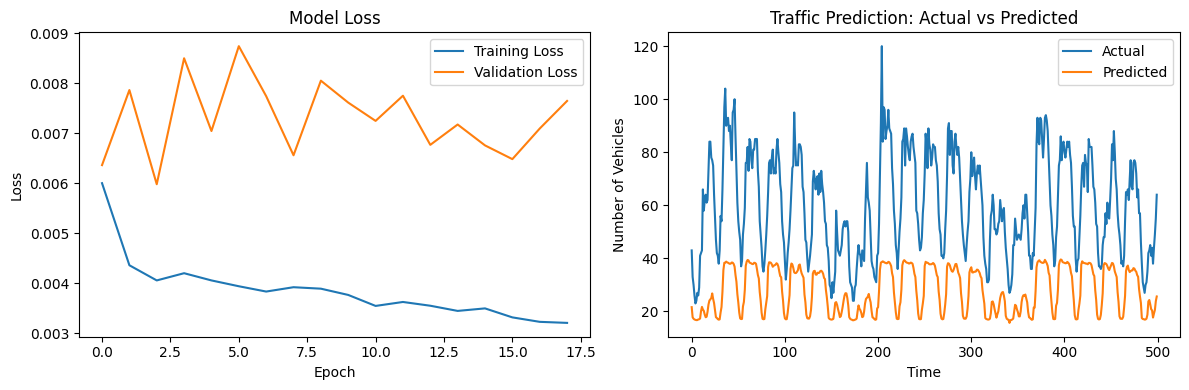

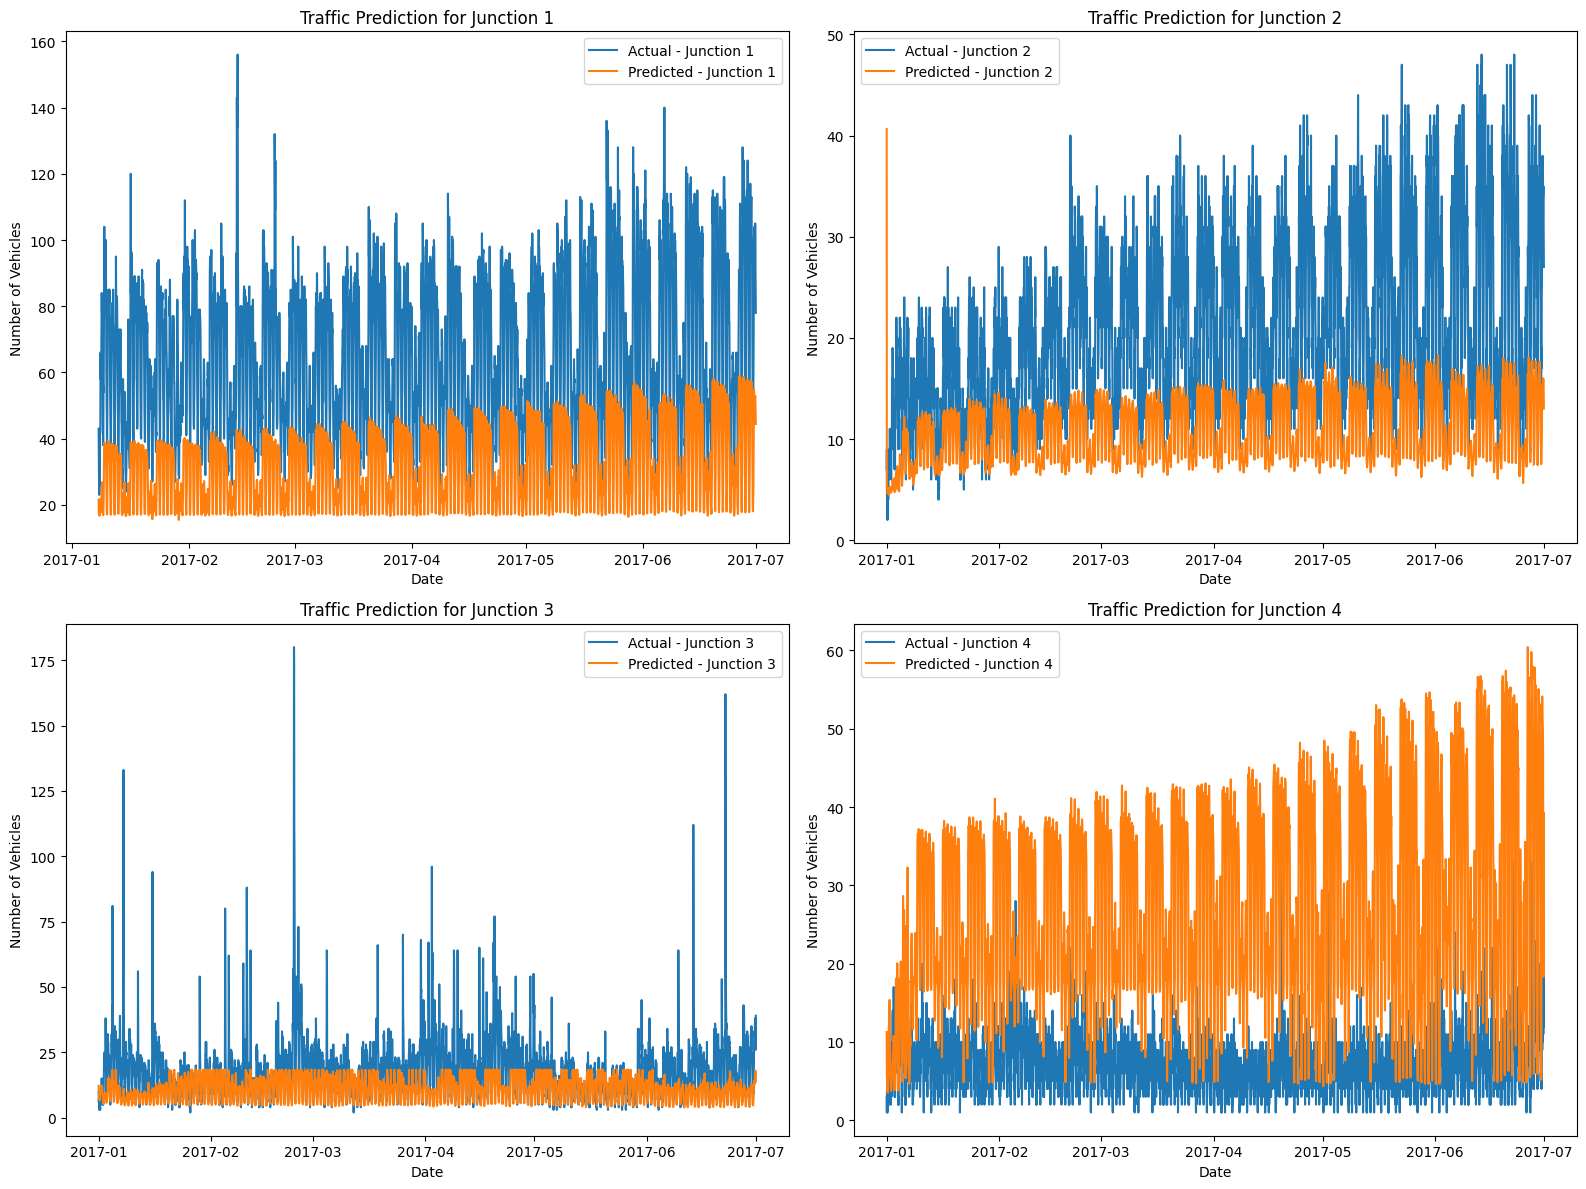


Performance by Junction:
Junction 1 - RMSE: 36.20, R²: -1.5304
Junction 2 - RMSE: 11.77, R²: -1.0318
Junction 3 - RMSE: 12.01, R²: -0.1060
Junction 4 - RMSE: 23.43, R²: -43.2815


In [19]:
def main():
    # Mount Google Drive (for Colab)
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        input_path = '/content/drive/MyDrive/Deep Learning Group 12/Deep Learning Group 12/traffic.csv'
    except:
        input_path = 'traffic.csv'  # Local path

    # Load and preprocess data
    df = load_data(input_path)
    df = preprocess_data(df)

    # Split data by time (train: 2015-2016, test: 2017)
    train_df = df[df['DateTime'].dt.year < 2017]
    test_df = df[df['DateTime'].dt.year == 2017]

    # Select features and target
    feature_columns = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos',
                       'month', 'day', 'junction_1', 'junction_2',
                       'junction_3', 'junction_4']
    target_column = 'Vehicles'

    # Scale the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    train_features = scaler_X.fit_transform(train_df[feature_columns])
    train_target = scaler_y.fit_transform(train_df[[target_column]])

    test_features = scaler_X.transform(test_df[feature_columns])
    test_target = scaler_y.transform(test_df[[target_column]])

    # Create sequences
    seq_length = 24 * 7  # Use 1 week of hourly data to predict the next hour
    X_train, y_train = create_sequences(train_features, train_target, seq_length)
    X_test, y_test = create_sequences(test_features, test_target, seq_length)

    print(f"Training data shape: {X_train.shape}, {y_train.shape}")
    print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)

    # Create validation set (20% of training data)
    val_size = int(0.2 * len(X_train_tensor))
    train_size = len(X_train_tensor) - val_size

    X_train_final = X_train_tensor[:train_size]
    y_train_final = y_train_tensor[:train_size]
    X_val = X_train_tensor[train_size:]
    y_val = y_train_tensor[train_size:]

    # Create DataLoaders
    batch_size = 32
    train_dataset = TensorDataset(X_train_final, y_train_final)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Model parameters
    input_dim = len(feature_columns)  # Original input dimension
    model_dim = 128  # Must be divisible by num_heads
    num_heads = 4
    ff_dim = 256
    num_transformer_blocks = 2
    lstm_units = [128, 64]
    mlp_units = [64, 32]
    dropout = 0.2
    mlp_dropout = 0.2

    # Initialize model
    model = HybridTransformerLSTM(
        input_dim=input_dim,
        seq_length=seq_length,
        model_dim=model_dim,
        num_heads=num_heads,
        ff_dim=ff_dim,
        num_transformer_blocks=num_transformer_blocks,
        lstm_units=lstm_units,
        mlp_units=mlp_units,
        dropout=dropout,
        mlp_dropout=mlp_dropout
    ).to(device)

    # Print model summary
    print(model)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params}")

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6, verbose=True
    )

    # Train the model
    num_epochs = 25
    patience = 15
    model, train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device, patience
    )

    # Save the model
    torch.save(model.state_dict(), 'hybrid_transformer_lstm_model.pth')

    # Evaluate the model
    model.eval()
    y_pred = []

    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            y_pred.extend(outputs.cpu().numpy())

    y_pred = np.array(y_pred)

    # Inverse transform to get actual values
    y_test_inv = scaler_y.inverse_transform(y_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred)

    # Calculate metrics
    rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    r2 = r2_score(y_test_inv, y_pred_inv)

    print(f"Test RMSE: {rmse:.2f}")
    print(f"Test R² Score: {r2:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot predictions vs actual
    plt.subplot(1, 2, 2)
    plt.plot(y_test_inv[:500], label='Actual')
    plt.plot(y_pred_inv[:500], label='Predicted')
    plt.title('Traffic Prediction: Actual vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Number of Vehicles')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Visualize predictions by junction
    test_with_preds = test_df.iloc[seq_length:seq_length+len(y_pred_inv)].copy()
    test_with_preds['Predicted'] = y_pred_inv.flatten()

    # Plot predictions for each junction
    plt.figure(figsize=(16, 12))
    for i, junction in enumerate([1, 2, 3, 4], 1):
        junction_data = test_with_preds[test_with_preds['Junction'] == junction]

        plt.subplot(2, 2, i)
        plt.plot(junction_data['DateTime'], junction_data['Vehicles'],
                 label=f'Actual - Junction {junction}')
        plt.plot(junction_data['DateTime'], junction_data['Predicted'],
                 label=f'Predicted - Junction {junction}')
        plt.title(f'Traffic Prediction for Junction {junction}')
        plt.xlabel('Date')
        plt.ylabel('Number of Vehicles')
        plt.legend()

    plt.tight_layout()
    plt.show()

    # Calculate metrics for each junction
    print("\nPerformance by Junction:")
    for junction in [1, 2, 3, 4]:
        junction_data = test_with_preds[test_with_preds['Junction'] == junction]
        junction_rmse = math.sqrt(mean_squared_error(
            junction_data['Vehicles'], junction_data['Predicted']))
        junction_r2 = r2_score(junction_data['Vehicles'], junction_data['Predicted'])
        print(f"Junction {junction} - RMSE: {junction_rmse:.2f}, R²: {junction_r2:.4f}")

if __name__ == "__main__":
    main()